In [ ]:
# Клонируем репозиторий Informer2020 с информером
!git clone https://github.com/zhouhaoyi/Informer2020.git
%cd Informer2020

# Устанавливаем зависимости
!pip install -r requirements.txt

Cloning into 'Informer2020'...
remote: Enumerating objects: 576, done.
remote: Total 576 (delta 0), reused 0 (delta 0), pack-reused 576 (from 1)
Receiving objects: 100% (576/576), 6.48 MiB | 5.58 MiB/s, done.
Resolving deltas: 100% (330/330), done.
/content/Informer2020
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 52.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 57.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× En

In [ ]:
# Важный момент!! Когда загружаем данные, там есть неправильная строка, так что мы ее поправляем:
filepath = "/content/Informer2020/utils/tools.py"

with open(filepath, "r") as file:
    content = file.read()

# Заменим строку, например:
content = content.replace("np.Inf", "np.inf")

with open(filepath, "w") as file:
    file.write(content)

In [ ]:
from google.colab import files
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
uploaded = files.upload()
# Чтение JSON-файла
df = pd.read_json(list(uploaded.keys())[0])

df.head()

Saving sber (1).json to sber (1).json


,date,close,open,low,high,trendclspr,volume,value,numtrades
0,2022-03-28,125.00,130.60,125.00,131.47,-4.94,33212430,4.203875e+09,121793
1,2022-03-29,128.77,126.16,122.00,137.57,3.02,72338740,9.470337e+09,184608
2,2022-03-30,134.60,136.89,131.11,138.40,4.53,35675450,4.754054e+09,102479
3,2022-03-31,143.69,135.25,134.52,147.41,6.75,118425000,1.666945e+10,255603
4,2022-04-01,154.50,145.00,144.51,155.40,7.52,118880720,1.802233e+10,265276


In [ ]:
# На всякий случай сортируем
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# Добавляем временные признаки
df["dayofweek"] = df["date"].dt.dayofweek
df["day"] = df["date"].dt.day
df["day_of_year"] = df["date"].dt.dayofyear
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

# Если в один день было несколько значений, то берем среднее
df = df.groupby("date", as_index=False).mean()
df = df.dropna()

# Создаём индексы без выходных
full_date_range = pd.date_range(df["date"].min(), df["date"].max(), freq="B")

df = df.set_index("date").reindex(full_date_range)
df = df.reset_index().rename(columns={"index": "date"})

# Линейно интерполируем пропуски, если они вдруг есть
df = df.interpolate()

%cd /content/Informer2020

# Сохраняем df в ./data/sber.csv
df.to_csv("data/sber.csv", index=False)

/content/Informer2020


In [ ]:
!python main_informer.py \
  --model informer \
  --data custom \
  --root_path ./data/ \
  --data_path sber.csv \
  --features MS\
  --enc_in 13\
  --dec_in 13\
  --c_out 1\
  --target close \
  --freq b \
  --checkpoints ./checkpoints \
  --seq_len 90 \
  --label_len 60 \
  --pred_len 1 \
  --e_layers 3 \
  --d_layers 2 \
  --d_model 512 \
  --n_heads 4 \
  --train_epochs 50 \
  --batch_size 32 \
  --patience 7

Args in experiment:
Namespace(model='informer', data='custom', root_path='./data/', data_path='sber.csv', features='MS', target='close', freq='b', checkpoints='./checkpoints', seq_len=90, label_len=60, pred_len=1, enc_in=13, dec_in=13, c_out=1, d_model=512, n_heads=4, e_layers=3, d_layers=2, s_layers=[3, 2, 1], d_ff=2048, factor=5, padding=0, distil=True, dropout=0.05, attn='prob', embed='timeF', activation='gelu', output_attention=False, do_predict=False, mix=True, cols=None, num_workers=0, itr=2, train_epochs=50, batch_size=32, patience=7, learning_rate=0.0001, des='test', loss='mse', lradj='type1', use_amp=False, inverse=False, use_gpu=False, gpu=0, use_multi_gpu=False, devices='0,1,2,3', detail_freq='b')
Use CPU
>>>>>>>start training : informer_custom_ftMS_sl90_ll60_pl1_dm512_nh4_el3_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 458
val 80
test 156
Epoch: 1 cost time: 76.811026096344
Epoch: 1, Steps: 14 | Train Loss: 1.1431945 Vali Loss: 0.25050

In [ ]:
# Путь к папке результатов (тут нужен свой)
result_folder = "/content/Informer2020/results/informer_custom_ftMS_sl60_ll60_pl1_dm512_nh4_el3_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_1"

# Смотрим, что внутри папки
print(os.listdir(result_folder))

# Считываем реальные данные и предсказанные
true = np.load(os.path.join(result_folder, "true.npy"))
preds = np.load(os.path.join(result_folder, "pred.npy"))

NameError: name 'os' is not defined

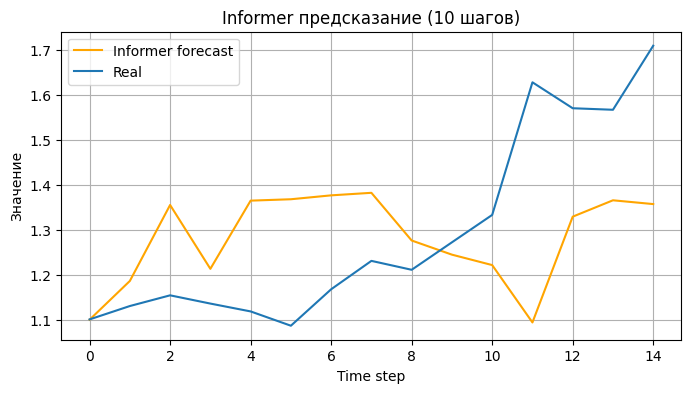

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot( np.concatenate(preds[-15:], axis=0), color='orange', label='Informer forecast')
plt.plot(np.concatenate(true[-15:], axis=0), label='Real')
plt.title("Informer предсказание")
plt.xlabel("Time step")
plt.ylabel("Значение")
plt.grid(True)
plt.legend()
plt.show()